In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load the dataset
df = pd.read_csv('news.csv')

# Extract features and labels
texts = df['text'].values
labels = df['label'].apply(lambda x: 1 if x == 'REAL' else 0).values

In [10]:
# Split dataset into training (80%) and temporary (20%)
x_train, x_temp, y_train, y_temp = train_test_split(
    df['text'], labels, test_size=0.2, random_state=7
)

# Split temporary set into development (10%) and testing (10%)
x_dev, x_test, y_dev, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=7
)

# Print sizes of each split
print(f"Training set size: {len(x_train)}")
print(f"Development set size: {len(x_dev)}")
print(f"Testing set size: {len(x_test)}")


Training set size: 5068
Development set size: 633
Testing set size: 634


In [14]:
# Tokenize the text data
max_words = 10000
max_len = 500
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_dev_seq = tokenizer.texts_to_sequences(x_dev)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad the sequences
x_train_padded = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_dev_padded = pad_sequences(x_dev_seq, maxlen=max_len, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')

In [12]:
# Build the TensorFlow model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\PMLS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Train the model
history = model.fit(
    x_train_padded, 
    y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(x_dev_padded, y_dev)
)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7701 - loss: 0.5134 - val_accuracy: 0.7678 - val_loss: 0.4906
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7990 - loss: 0.4396 - val_accuracy: 0.7472 - val_loss: 0.5474
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8341 - loss: 0.3499 - val_accuracy: 0.7346 - val_loss: 0.5700
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8445 - loss: 0.3210 - val_accuracy: 0.7188 - val_loss: 0.6544
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8520 - loss: 0.2930 - val_accuracy: 0.7583 - val_loss: 0.6768
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8632 - loss: 0.2732 - val_accuracy: 0.7551 - val_loss: 0.8791
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 55s 683ms/step - accuracy: 0.8640 - loss: 0.2706 - val_accuracy: 0.7788 - val_loss: 0.6473
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8967 - loss: 0.2501 - val_accuracy: 0.8483 -

In [16]:
# Evaluate the model on the development set
y_dev_pred_probs = model.predict(x_dev_padded)  # Predict probabilities
y_dev_pred = (y_dev_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy on the development set
dev_accuracy = accuracy_score(y_dev, y_dev_pred)
print(f'Development Set Accuracy: {round(dev_accuracy * 100, 2)}%')

# Confusion matrix for the development set
dev_conf_matrix = confusion_matrix(y_dev, y_dev_pred)
print("Development Set Confusion Matrix:")
print(dev_conf_matrix)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step
Development Set Accuracy: 82.46%
Development Set Confusion Matrix:
[[245  68]
 [ 43 277]]


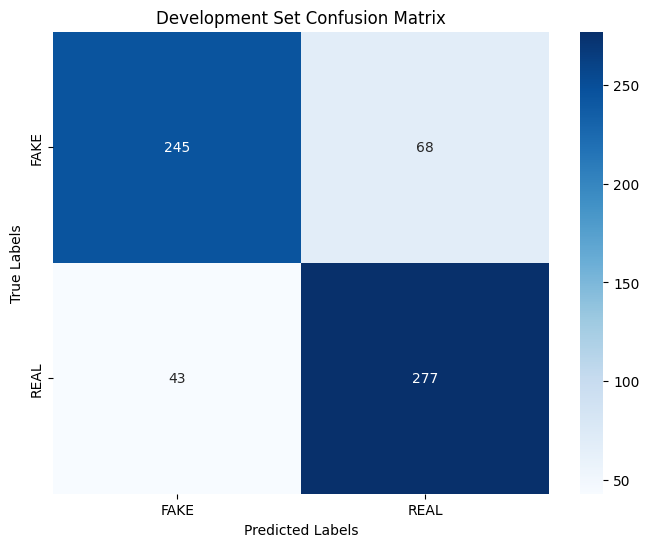

In [17]:
# Plot confusion matrix for the development set
plt.figure(figsize=(8, 6))
sns.heatmap(dev_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title('Development Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
# Evaluate the model on the test set
y_test_pred_probs = model.predict(x_test_padded)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Set Accuracy: {round(test_accuracy * 100, 2)}%')

# Confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Test Set Confusion Matrix:")
print(test_conf_matrix)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step
Test Set Accuracy: 79.34%
Test Set Confusion Matrix:
[[252  73]
 [ 58 251]]


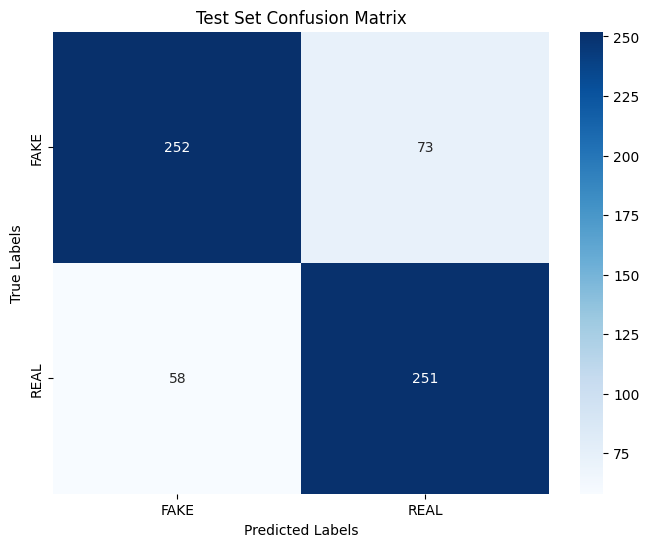

In [19]:
# Plot confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

C:\Users\PMLS\AppData\Local\Temp\ipykernel_23952\3742801462.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_df, x='Dataset', y='Accuracy', palette='viridis')


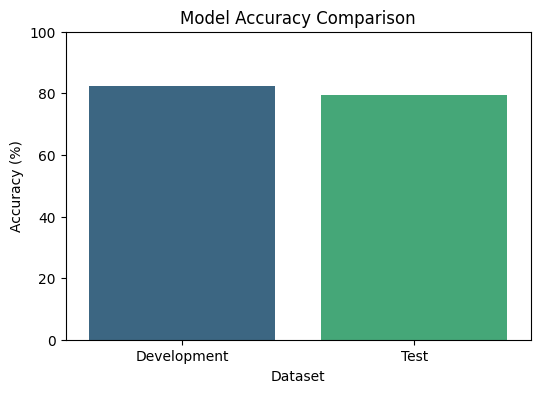

In [20]:
# Create a DataFrame for accuracy comparison
accuracy_scores = {'Dataset': ['Development', 'Test'], 'Accuracy': [dev_accuracy * 100, test_accuracy * 100]}
accuracy_df = pd.DataFrame(accuracy_scores)

# Plot accuracy comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=accuracy_df, x='Dataset', y='Accuracy', palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.xlabel('Dataset')
plt.show()
